In [21]:
# pip install pandas seaborn mysqlclient sklearn adjusttext

In [22]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import seaborn as sns

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

#from scipy.cluster import hierarchy, dendrogram, linkage
from scipy.spatial import ConvexHull

from adjustText import adjust_text
from collections import defaultdict

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

In [23]:
players_df_full = pd.read_csv("./league/LaLiga.csv")
players_df_full.set_index('name', inplace=True, drop=True)
players_df_full.drop_duplicates(inplace=True)
players_df_full.head()

,league_name,team_name,flag,age,position,tall,weight,full_time,half_time,minsPlayed,...,dribbleWonPerGame,foulGivenPerGame,offsideGivenPerGame,dispossessedPerGame,turnoverPerGame,totalPassesPerGame,passSuccess_y,accurateCrossesPerGame,accurateLongPassPerGame,accurateThroughBallPerGame
name,,,,,,,,,,,,,,,,,,,,,
Lionel Messi,LaLiga,Barcelona,ar,32,"AM(CR),FW",170,72,10,1,901,...,5.1,1.0,0.4,1.9,2.0,52.7,81.4,0.5,1.7,0.5
Luis Suárez,LaLiga,Barcelona,uy,32,"AM(CLR),FW",182,86,12,2,1014,...,1.0,0.7,0.6,0.7,0.9,23.3,73.6,0.1,1.2,0.0
Arthur,LaLiga,Barcelona,br,23,DMC,171,73,8,1,655,...,2.2,2.7,0.1,1.1,1.9,55.8,89.8,0.1,3.0,0.1
Antoine Griezmann,LaLiga,Barcelona,fr,28,"AM(CLR),FW",176,73,14,1,1217,...,0.6,0.5,0.6,0.5,1.5,36.1,80.0,0.1,1.2,0.1
Frenkie de Jong,LaLiga,Barcelona,nl,22,"D(C),DMC",180,74,15,1,1262,...,1.9,1.1,0.1,0.9,1.0,59.2,92.9,0.1,2.4,0.1


## Data cleansing

**Remove features**: There are lots of different features on each player, but we don't want to use all of them since they may be irrelevant for our goal. For example, the number of games played or player's age are not features that we would like to be used for our segmentation.  

**Feature extraction**: We can infere some features based on others, such as...

**Subsetting data**: There are hundreds of players in european teams, which are too many for our purpose here. For that reason, we'll only work with the most *interesting* players, defining interesting as the players who played the most. We'll set the threshold on the 80% percentile


In [24]:
# Filter by players who played the most. Remove goalkeepers
players_df = players_df_full.copy()

# Create a new feature "main position"
def main_position_func(position):
    main_positions_dic = {
        'F': 'Forward',
        'A': 'Attacker',
        'M': 'Midfielder',
        'D': 'Defender',
        'G': 'GoalKeeper',
        'S': 'Subsitute',
    }
    return main_positions_dic[position.strip()[0]]

players_df['position'] = players_df['position'].map(main_position_func)

# Remove players who have not played in the top 20%. But leave Messi just in case...
players_df = players_df[(players_df.minsPlayed > players_df.minsPlayed.quantile(0.80)) | (players_df.index == 'Lionel Messi')]

# Remove features we don't need
players_df.drop(columns=['league_name', 'team_name', 'flag', 'full_time', 'half_time', 'rating', 'passSuccess_y', 'shotsPerGame_y'], 
                             axis=1,
                             inplace=True)

# Translate column names to spanish for presentation purposes
players_df.rename(columns={
    'age': 'Edad',
    'position': 'Posicion', 
    'minsPlayed': 'Minutos',
    'tall': 'Altura',
    'weight': 'Peso',
    'goals': 'T_Goles',
    'asistsTotal': 'T_Asistencias',
    'yellowCards': 'T_Amarillas',
    'redCards': 'T_Rojas',
    'shotsPerGame_x': 'PP_Tiros',
    'passSuccess_x': '%_PasesBuenos',
    'manOfTheMatch': 'JdP',
    'aerialWonPerGame': 'PP_Aire',
    'tacklePerGame': 'PP_Entradas',
    'interceptionPerGame': 'PP_Intercepciones',
    'foulsPerGame': 'PP_Faltas',
    'offsideWonPerGame': 'PP_FueraJuegoGanados',
    'clearancePerGame': 'PP_Despejes',
    'wasDribbledPerGame': 'PP_Regateado',
    'goalOwn': 'T_GolesPropia',
    'keyPassPerGame': 'PP_PasesClave',
    'dribbleWonPerGame': 'PP_Regateo',
    'foulGivenPerGame':'PP_FaltaRecibida',
    'offsideGivenPerGame': 'PP_FueraJuegoPerdido',
    'turnoverPerGame': 'PP_MalControl',
    'dispossessedPerGame': 'PP_BalonPerdido',
    'totalPassesPerGame': 'PP_Pases',
    'accurateLongPassPerGame': 'PP_PaseLargo',
    'accurateThroughBallPerGame': 'PP_PaseProfundidad',
    'accurateCrossesPerGame': 'PP_PaseCentro'
},
                 inplace=True)


players_df.head()

,Edad,Posicion,Altura,Peso,Minutos,T_Goles,T_Asistencias,T_Amarillas,T_Rojas,PP_Tiros,...,PP_PasesClave,PP_Regateo,PP_FaltaRecibida,PP_FueraJuegoPerdido,PP_BalonPerdido,PP_MalControl,PP_Pases,PP_PaseCentro,PP_PaseLargo,PP_PaseProfundidad
name,,,,,,,,,,,,,,,,,,,,,
Lionel Messi,32,Attacker,170,72,901,12,6,1,0,3.6,...,2.7,5.1,1.0,0.4,1.9,2.0,52.7,0.5,1.7,0.5
Antoine Griezmann,28,Attacker,176,73,1217,6,4,2,0,2.0,...,0.8,0.6,0.5,0.6,0.5,1.5,36.1,0.1,1.2,0.1
Frenkie de Jong,22,Defender,180,74,1262,1,2,1,0,0.1,...,1.1,1.9,1.1,0.1,0.9,1.0,59.2,0.1,2.4,0.1
Gerard Piqué,32,Defender,194,85,1343,1,0,8,0,0.5,...,0.3,0.2,0.5,0.0,0.2,0.4,71.2,0.0,4.7,0.0
Marc-André ter Stegen,27,GoalKeeper,187,85,1440,0,2,0,0,0.0,...,0.1,0.0,0.1,0.0,0.0,0.0,27.3,0.0,5.9,0.1


## Scaling
Before building the model, we need to scale and normalize our data.

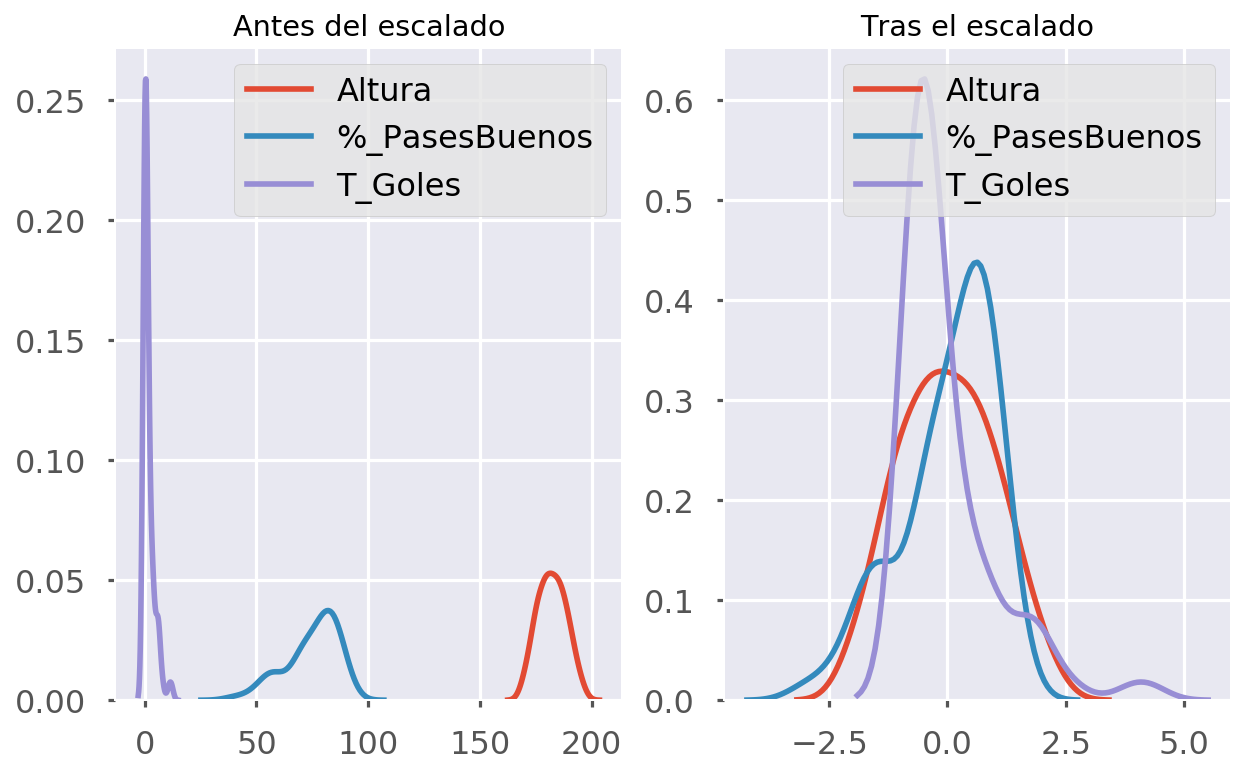

In [25]:
#https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set

scaled_features = StandardScaler().fit_transform(players_df.drop('Posicion', axis=1))
players_df_scaled = pd.DataFrame(scaled_features, index=players_df.drop('Posicion', axis=1).index, columns=players_df.drop('Posicion', axis=1).columns)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))

ax1.set_facecolor('#E8E8F1')
ax2.set_facecolor('#E8E8F1')

ax1.set_title('Antes del escalado')
sns.kdeplot(players_df['Altura'], ax=ax1)
sns.kdeplot(players_df['%_PasesBuenos'], ax=ax1)
sns.kdeplot(players_df['T_Goles'], ax=ax1)
ax2.set_title('Tras el escalado')
sns.kdeplot(players_df_scaled['Altura'], ax=ax2)
sns.kdeplot(players_df_scaled['%_PasesBuenos'], ax=ax2)
sns.kdeplot(players_df_scaled['T_Goles'], ax=ax2)
plt.show()


## Correlation Matrix
With the 30 features selected, the first thing we'll do is run a correlation matrix to see if we see any interesting correlation. This will also help us see if our data "seems" ok, since some correlations should be very obvious. 

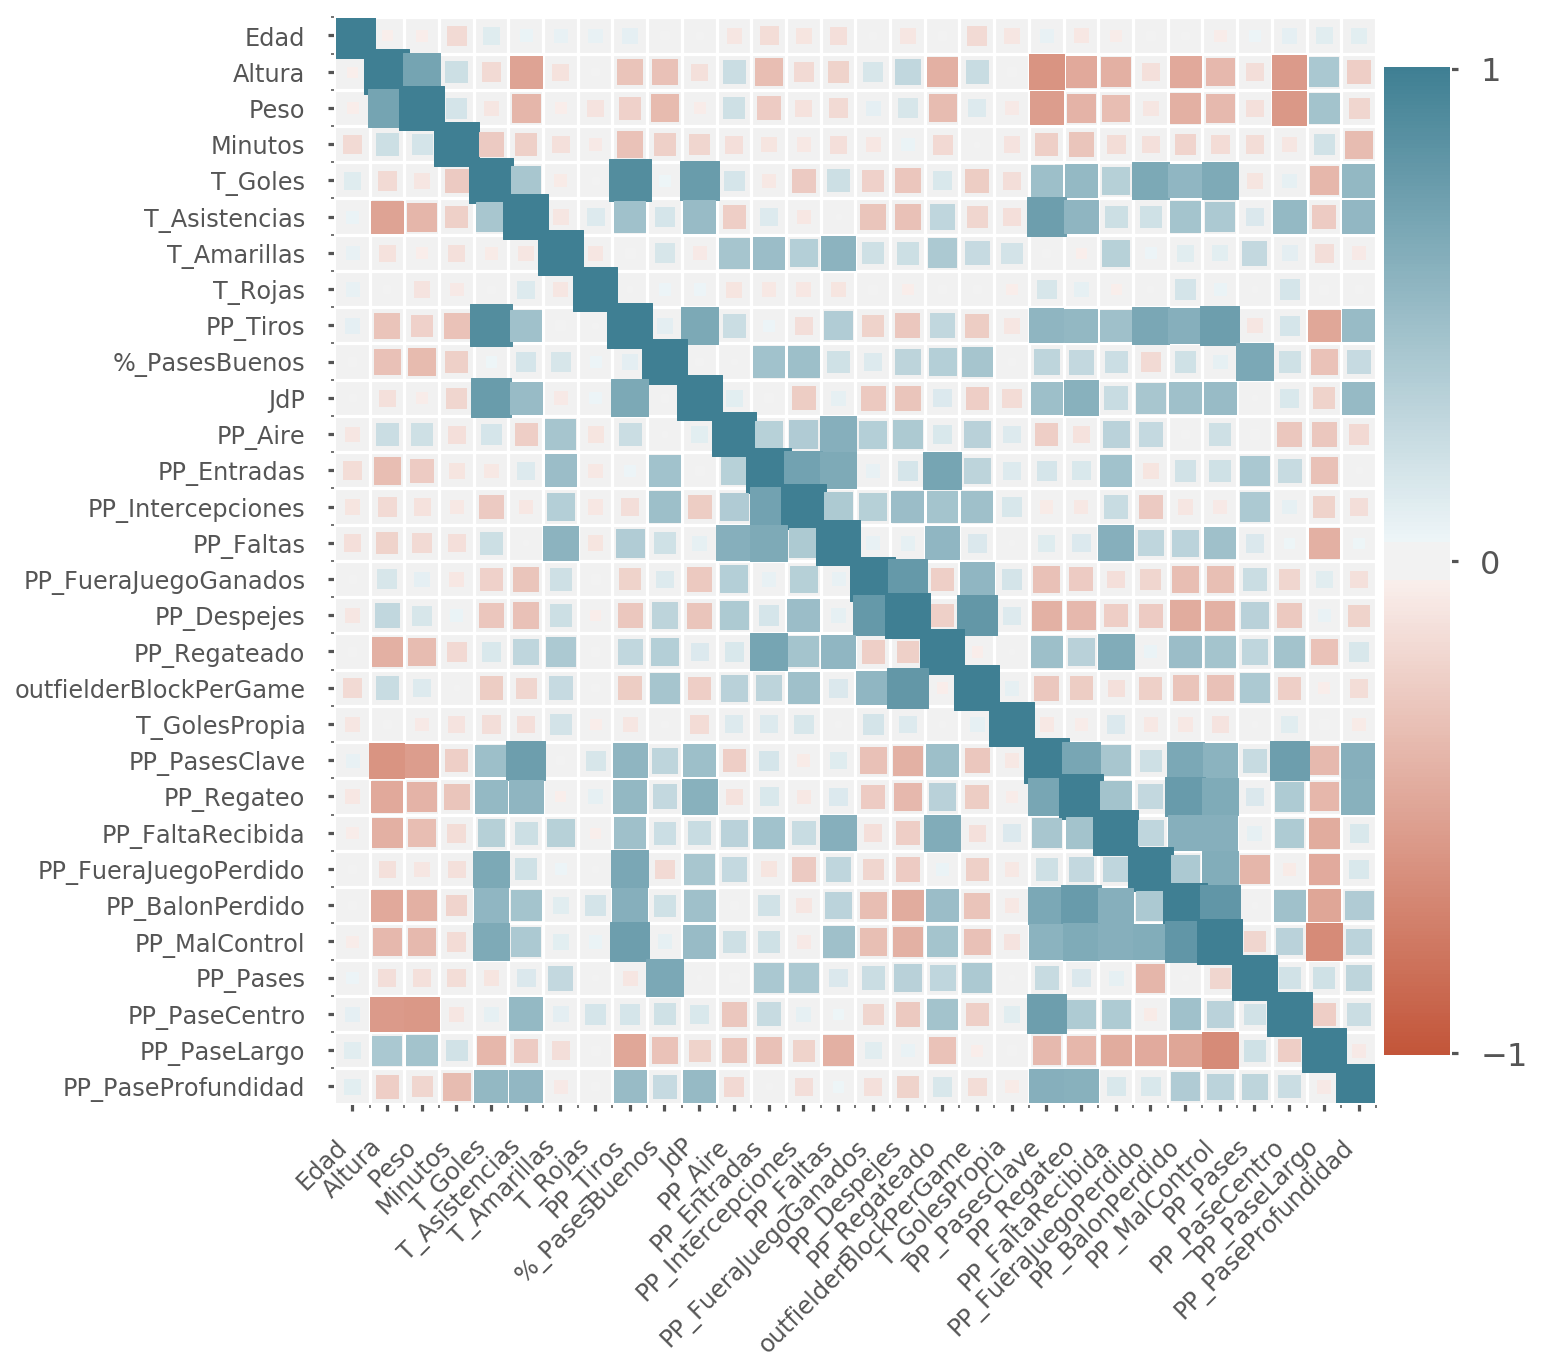

In [26]:
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right', fontsize=12)
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num], fontsize=12)

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )


plt.figure(figsize=(10, 10))
corr = players_df_scaled.corr()
corrplot(corr)

# Simplifying the features

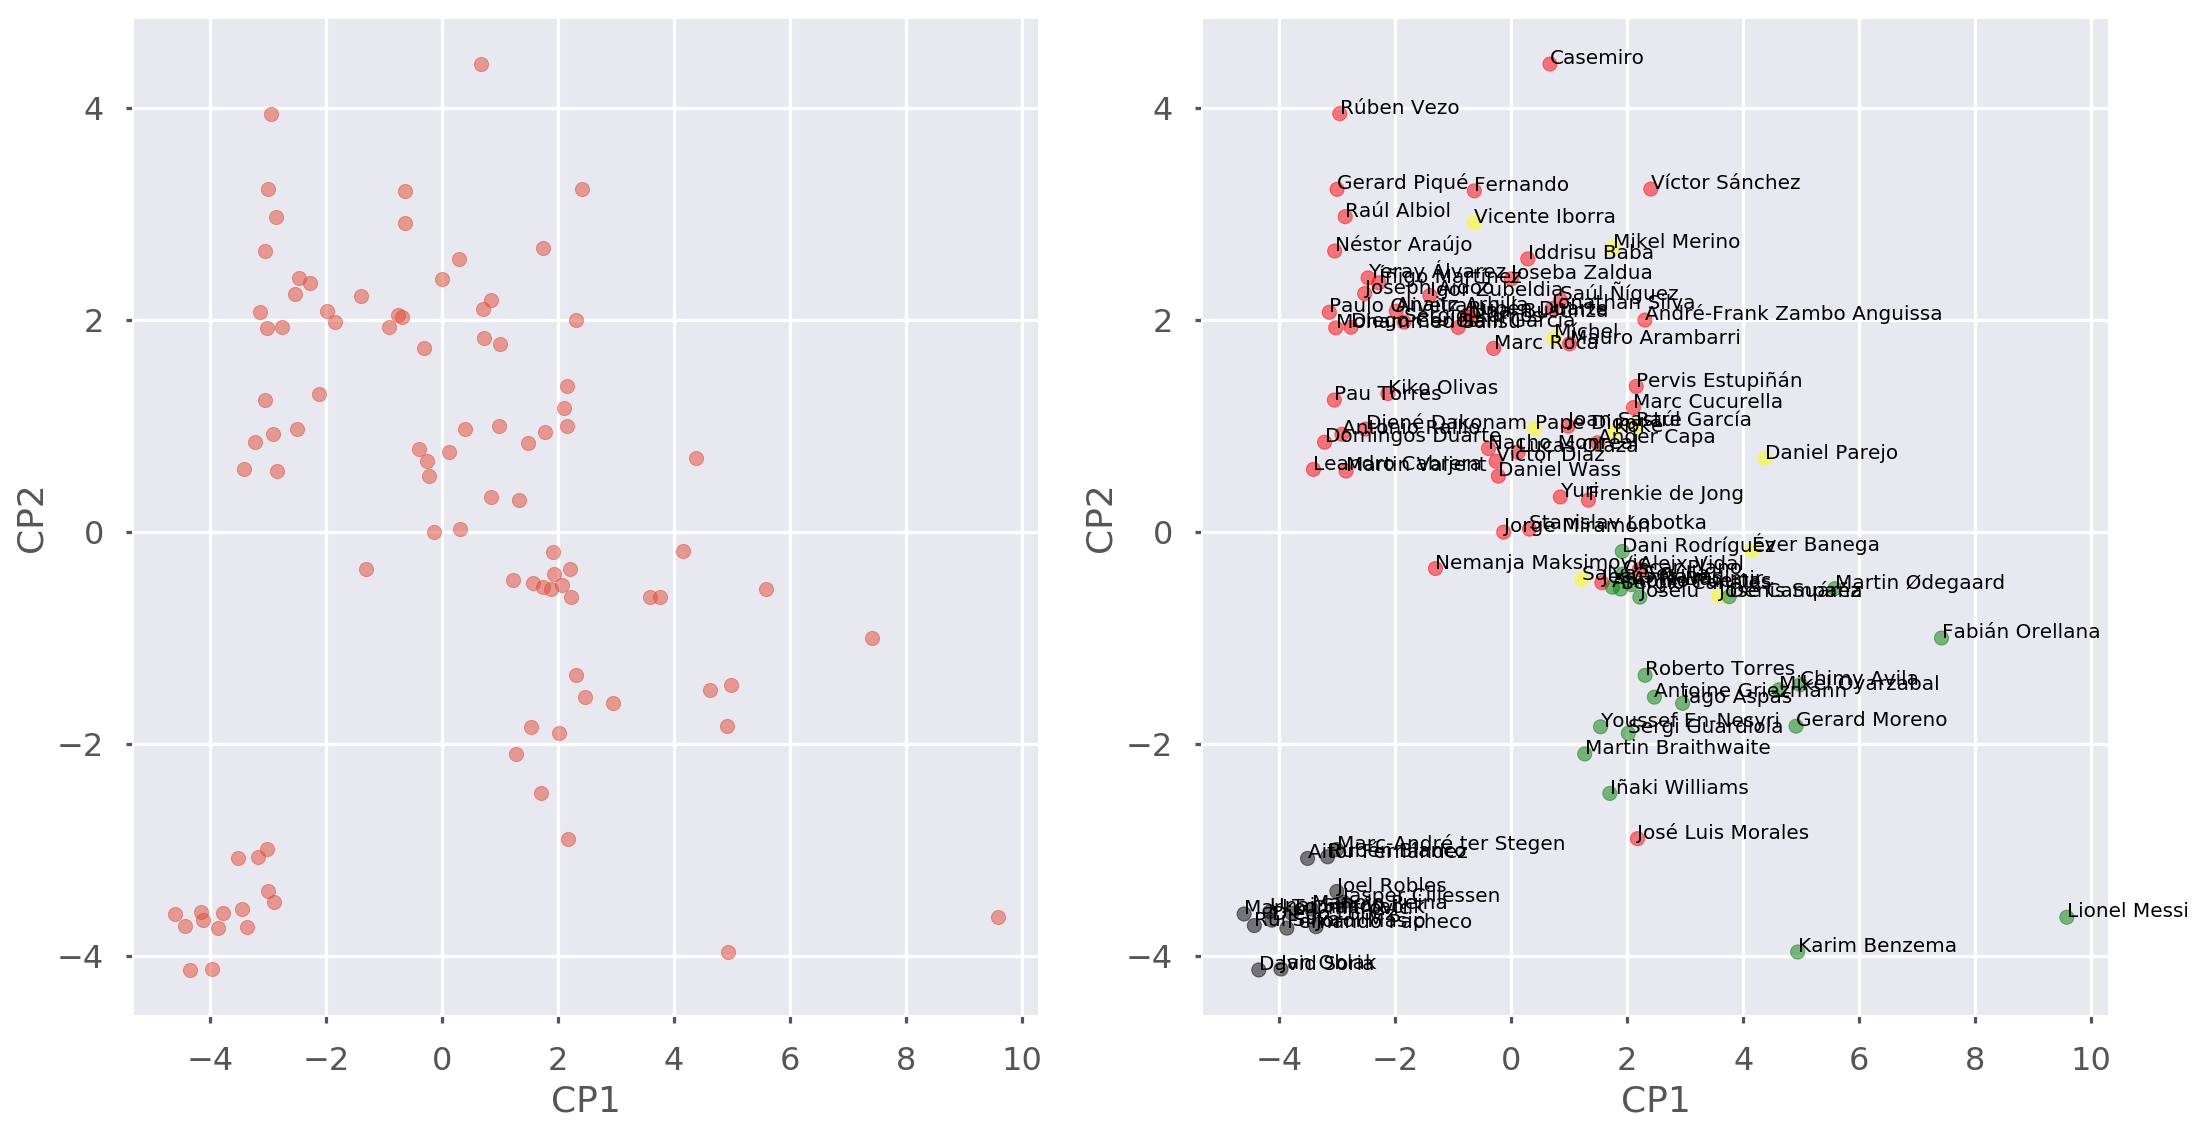

In [27]:
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

# Create features PC1 and PC2 using PCA
features_pca = PCA(n_components = 2).fit_transform(players_df_scaled)
principal_df = pd.DataFrame(features_pca, index=players_df_scaled.index, columns=["PC1", "PC2"])

# Plotting 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.set_facecolor('#E8E8F1')
ax2.set_facecolor('#E8E8F1')

ax1.set_xlabel('CP1', fontsize=18)
ax1.set_ylabel('CP2', fontsize=18)
ax2.set_xlabel('CP1', fontsize=18)
ax2.set_ylabel('CP2', fontsize=18)

pos_colors = {
    'GoalKeeper': 'black', 
    'Defender': 'red',
    'Midfielder': 'yellow',
    'Attacker': 'green',
    'Forward': 'green'
}

ax1.scatter(principal_df['PC1'], principal_df['PC2'], marker='o', s=50, alpha=0.5, cmap='viridis')
ax2.scatter(principal_df['PC1'], principal_df['PC2'], c=players_df['Posicion'].apply(lambda x: pos_colors[x]), marker='o', s=50, alpha=0.5, cmap='viridis')

texts = [plt.text(principal_df['PC1'][name], principal_df['PC2'][name], name) for name in principal_df.index]
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='#999999'))

plt.tight_layout()
plt.show()



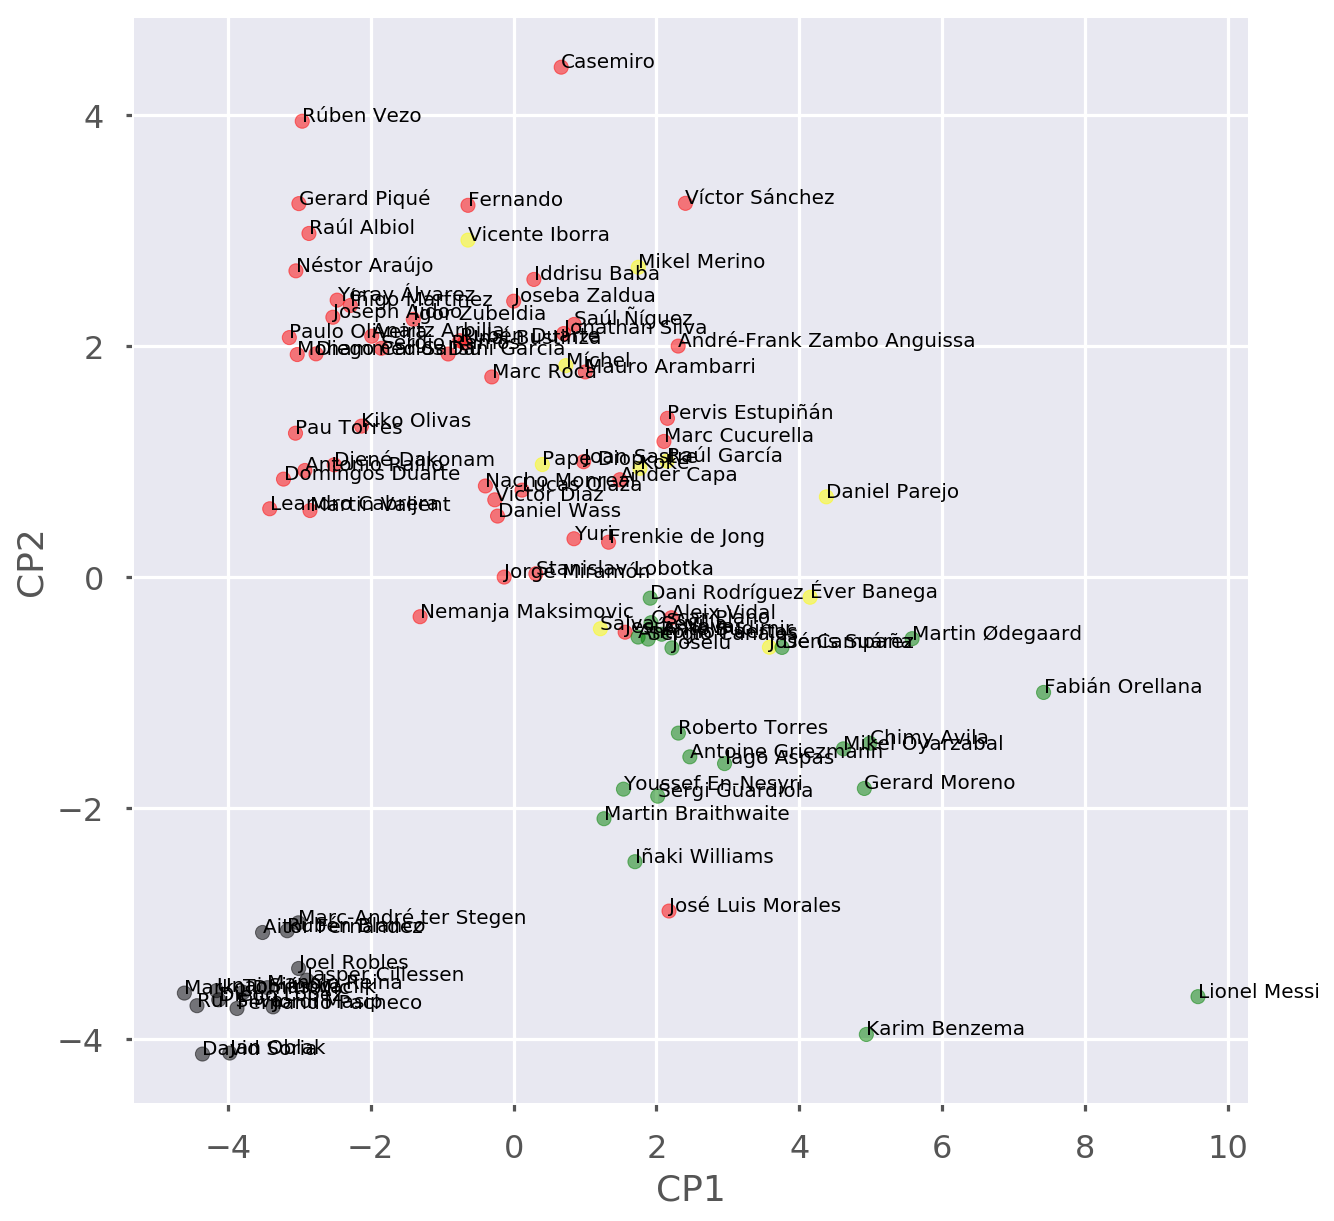

In [28]:
plt.figure(figsize=(10, 10))
ax = plt.axes()

ax.set_facecolor('#E8E8F1')

plt.xlabel('CP1', fontsize=18)
plt.ylabel('CP2', fontsize=18)

pos_colors = {
    'GoalKeeper': 'black', 
    'Defender': 'red',
    'Midfielder': 'yellow',
    'Attacker': 'green',
    'Forward': 'green'
}

plt.scatter(principal_df['PC1'], principal_df['PC2'], c=players_df['Posicion'].apply(lambda x: pos_colors[x]), marker='o', s=50, alpha=0.5, cmap='viridis')
texts = [plt.text(principal_df['PC1'][name], principal_df['PC2'][name], name) for name in principal_df.index]
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='#999999'))




# Clustering
To determine the best number of clusters we'll use the elbow method. 

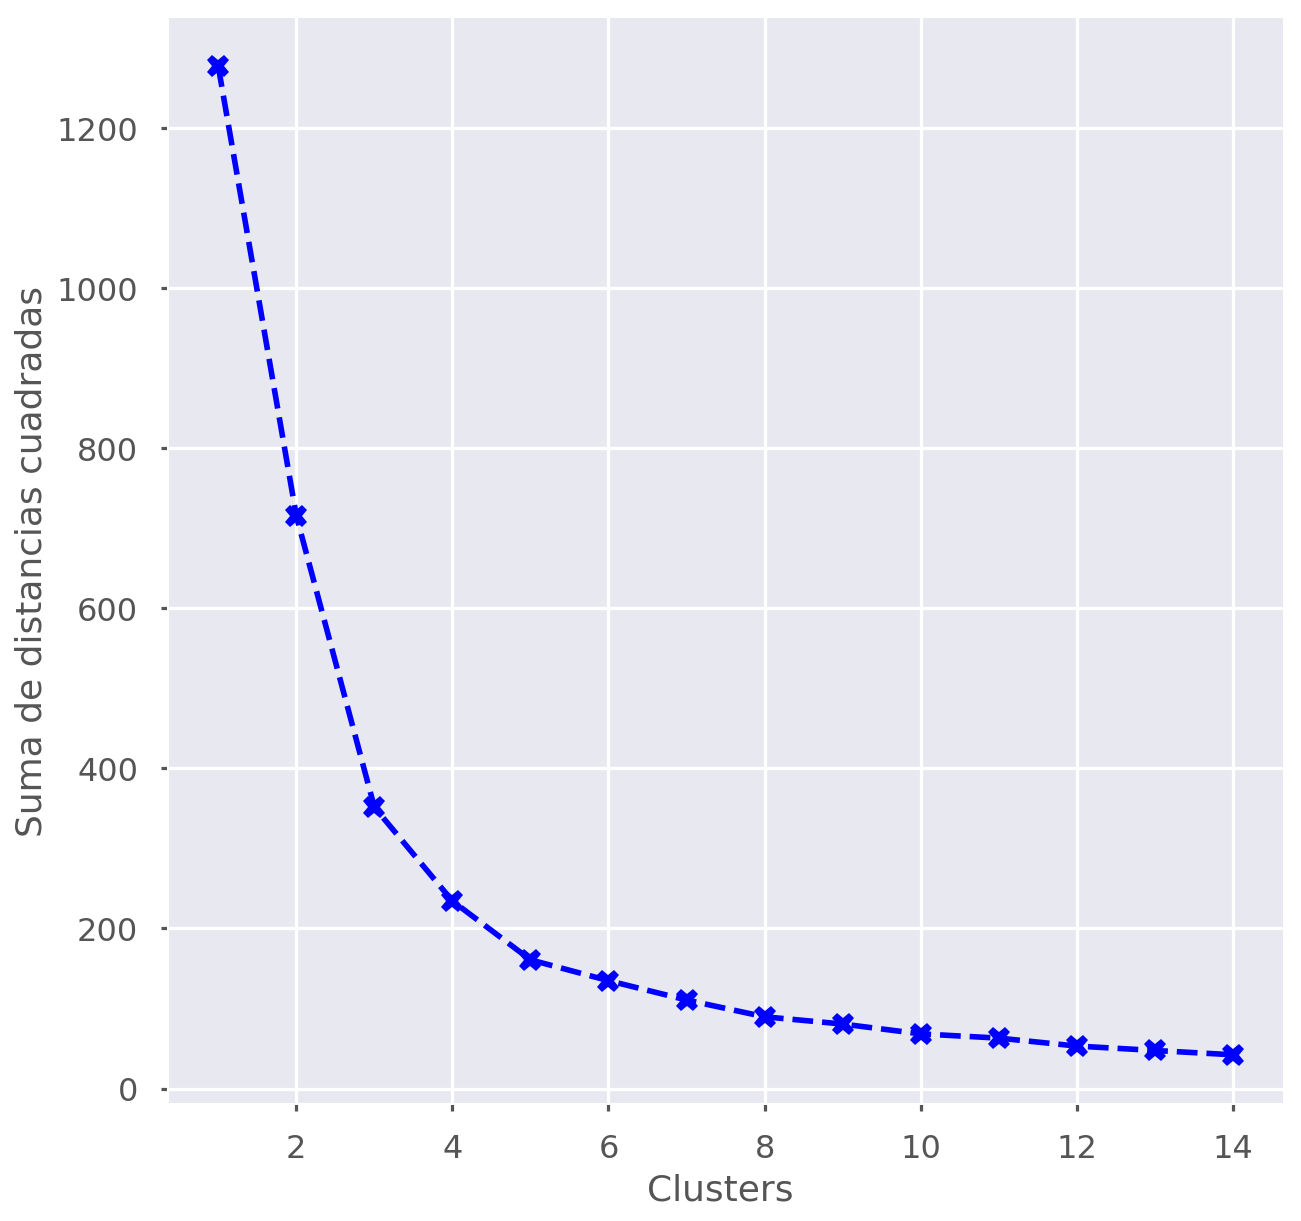

In [29]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(principal_df)
    sum_of_squared_distances.append(km.inertia_)
    
plt.figure(figsize=(10, 10))
ax = plt.axes()
plt.xlabel('Clusters ', fontsize=18)
plt.ylabel('Suma de distancias cuadradas', fontsize=18)
ax.set_facecolor('#E8E8F1')

plt.plot(K, sum_of_squared_distances, linestyle='--', color='blue', marker='X')


plt.show()

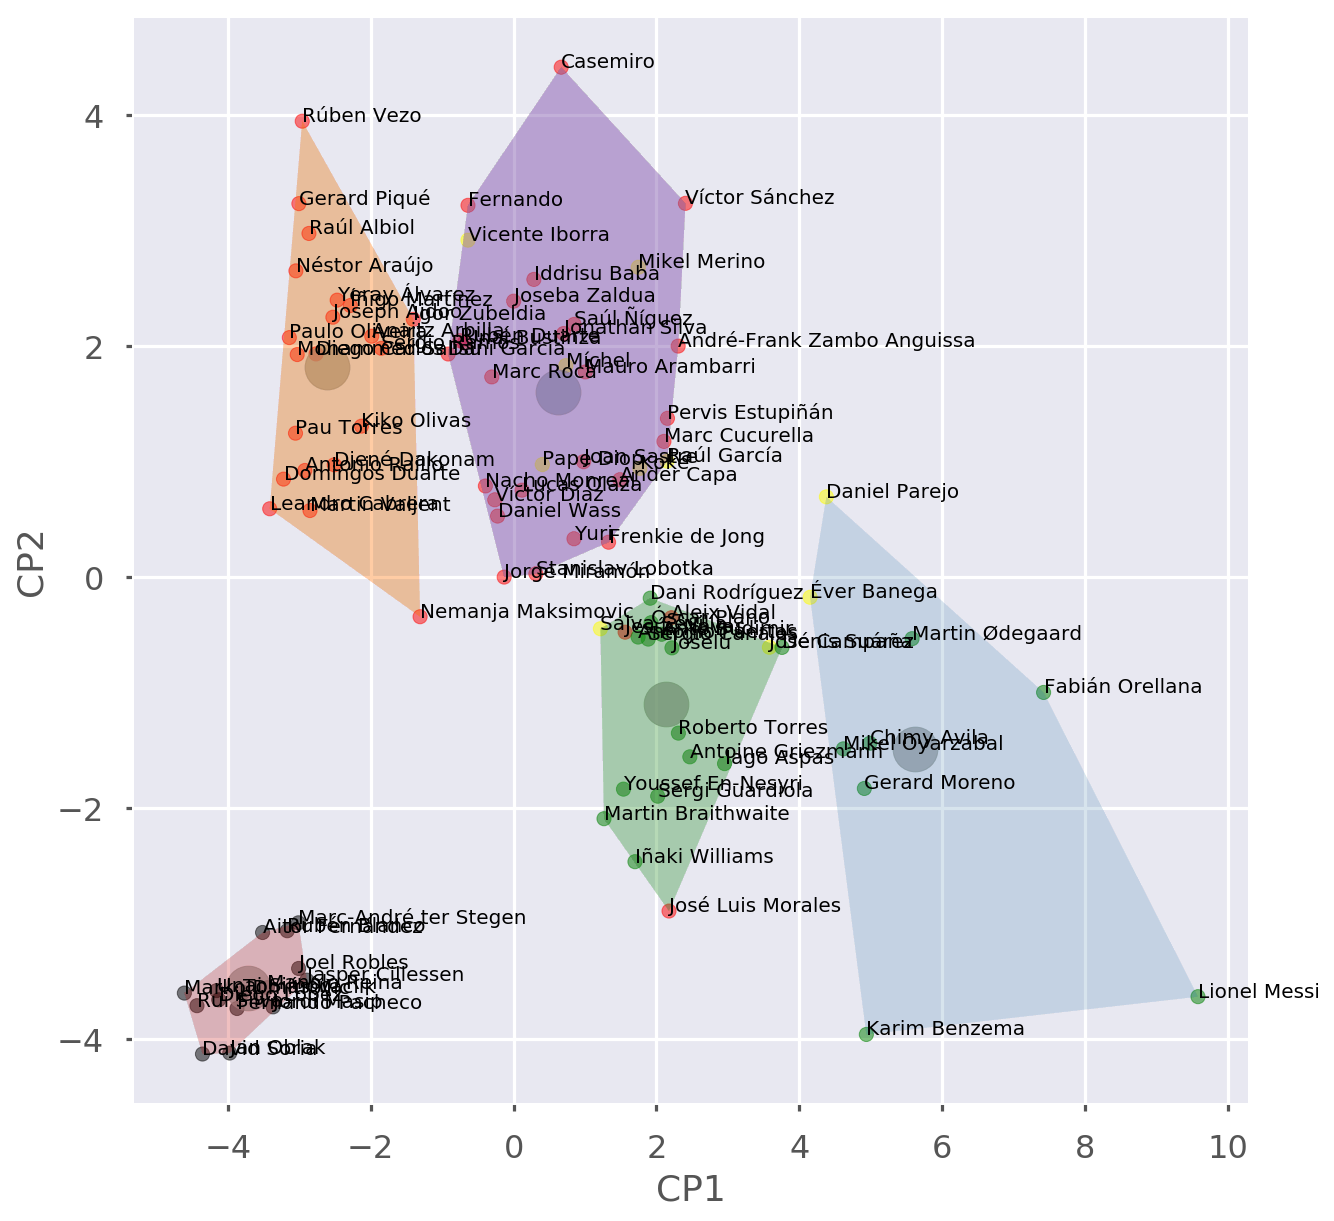

In [30]:
# Create clusters
n_clusters = 5
kmeans = cluster.KMeans(n_clusters)
y_kmeans = kmeans.fit_predict(principal_df)

# Draw clusters
plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.set_facecolor('#E8E8F1')
plt.xlabel('CP1', fontsize=18)
plt.ylabel('CP2', fontsize=18)

#y_kmeans = kmeans.predict(df.drop('name', axis=1))

pos_colors = {
    'GoalKeeper': 'black', 
    'Defender': 'red',
    'Midfielder': 'yellow',
    'Attacker': 'green',
    'Forward': 'green'
}
plt.scatter(principal_df['PC1'], principal_df['PC2'], marker='o', c=players_df['Posicion'].apply(lambda x: pos_colors[x]), cmap="Paired", s=50, alpha=0.5)

# Draw centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', c='#999999', s=500, alpha=0.7)

texts = [plt.text(principal_df['PC1'][name], principal_df['PC2'][name], name) for name in principal_df['PC1'].index]
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='#999999'))

# Draw poligons around clusters
# https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)


# Draw polygon surrounding vertices
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i in y_kmeans:
    encircle(principal_df.loc[kmeans.labels_ == i, 'PC1'], principal_df.loc[kmeans.labels_ == i, 'PC2'], ec="k", fc=colors[i], alpha=0.02, linewidth=0)

# Agglomerative Hierarchical Clustering

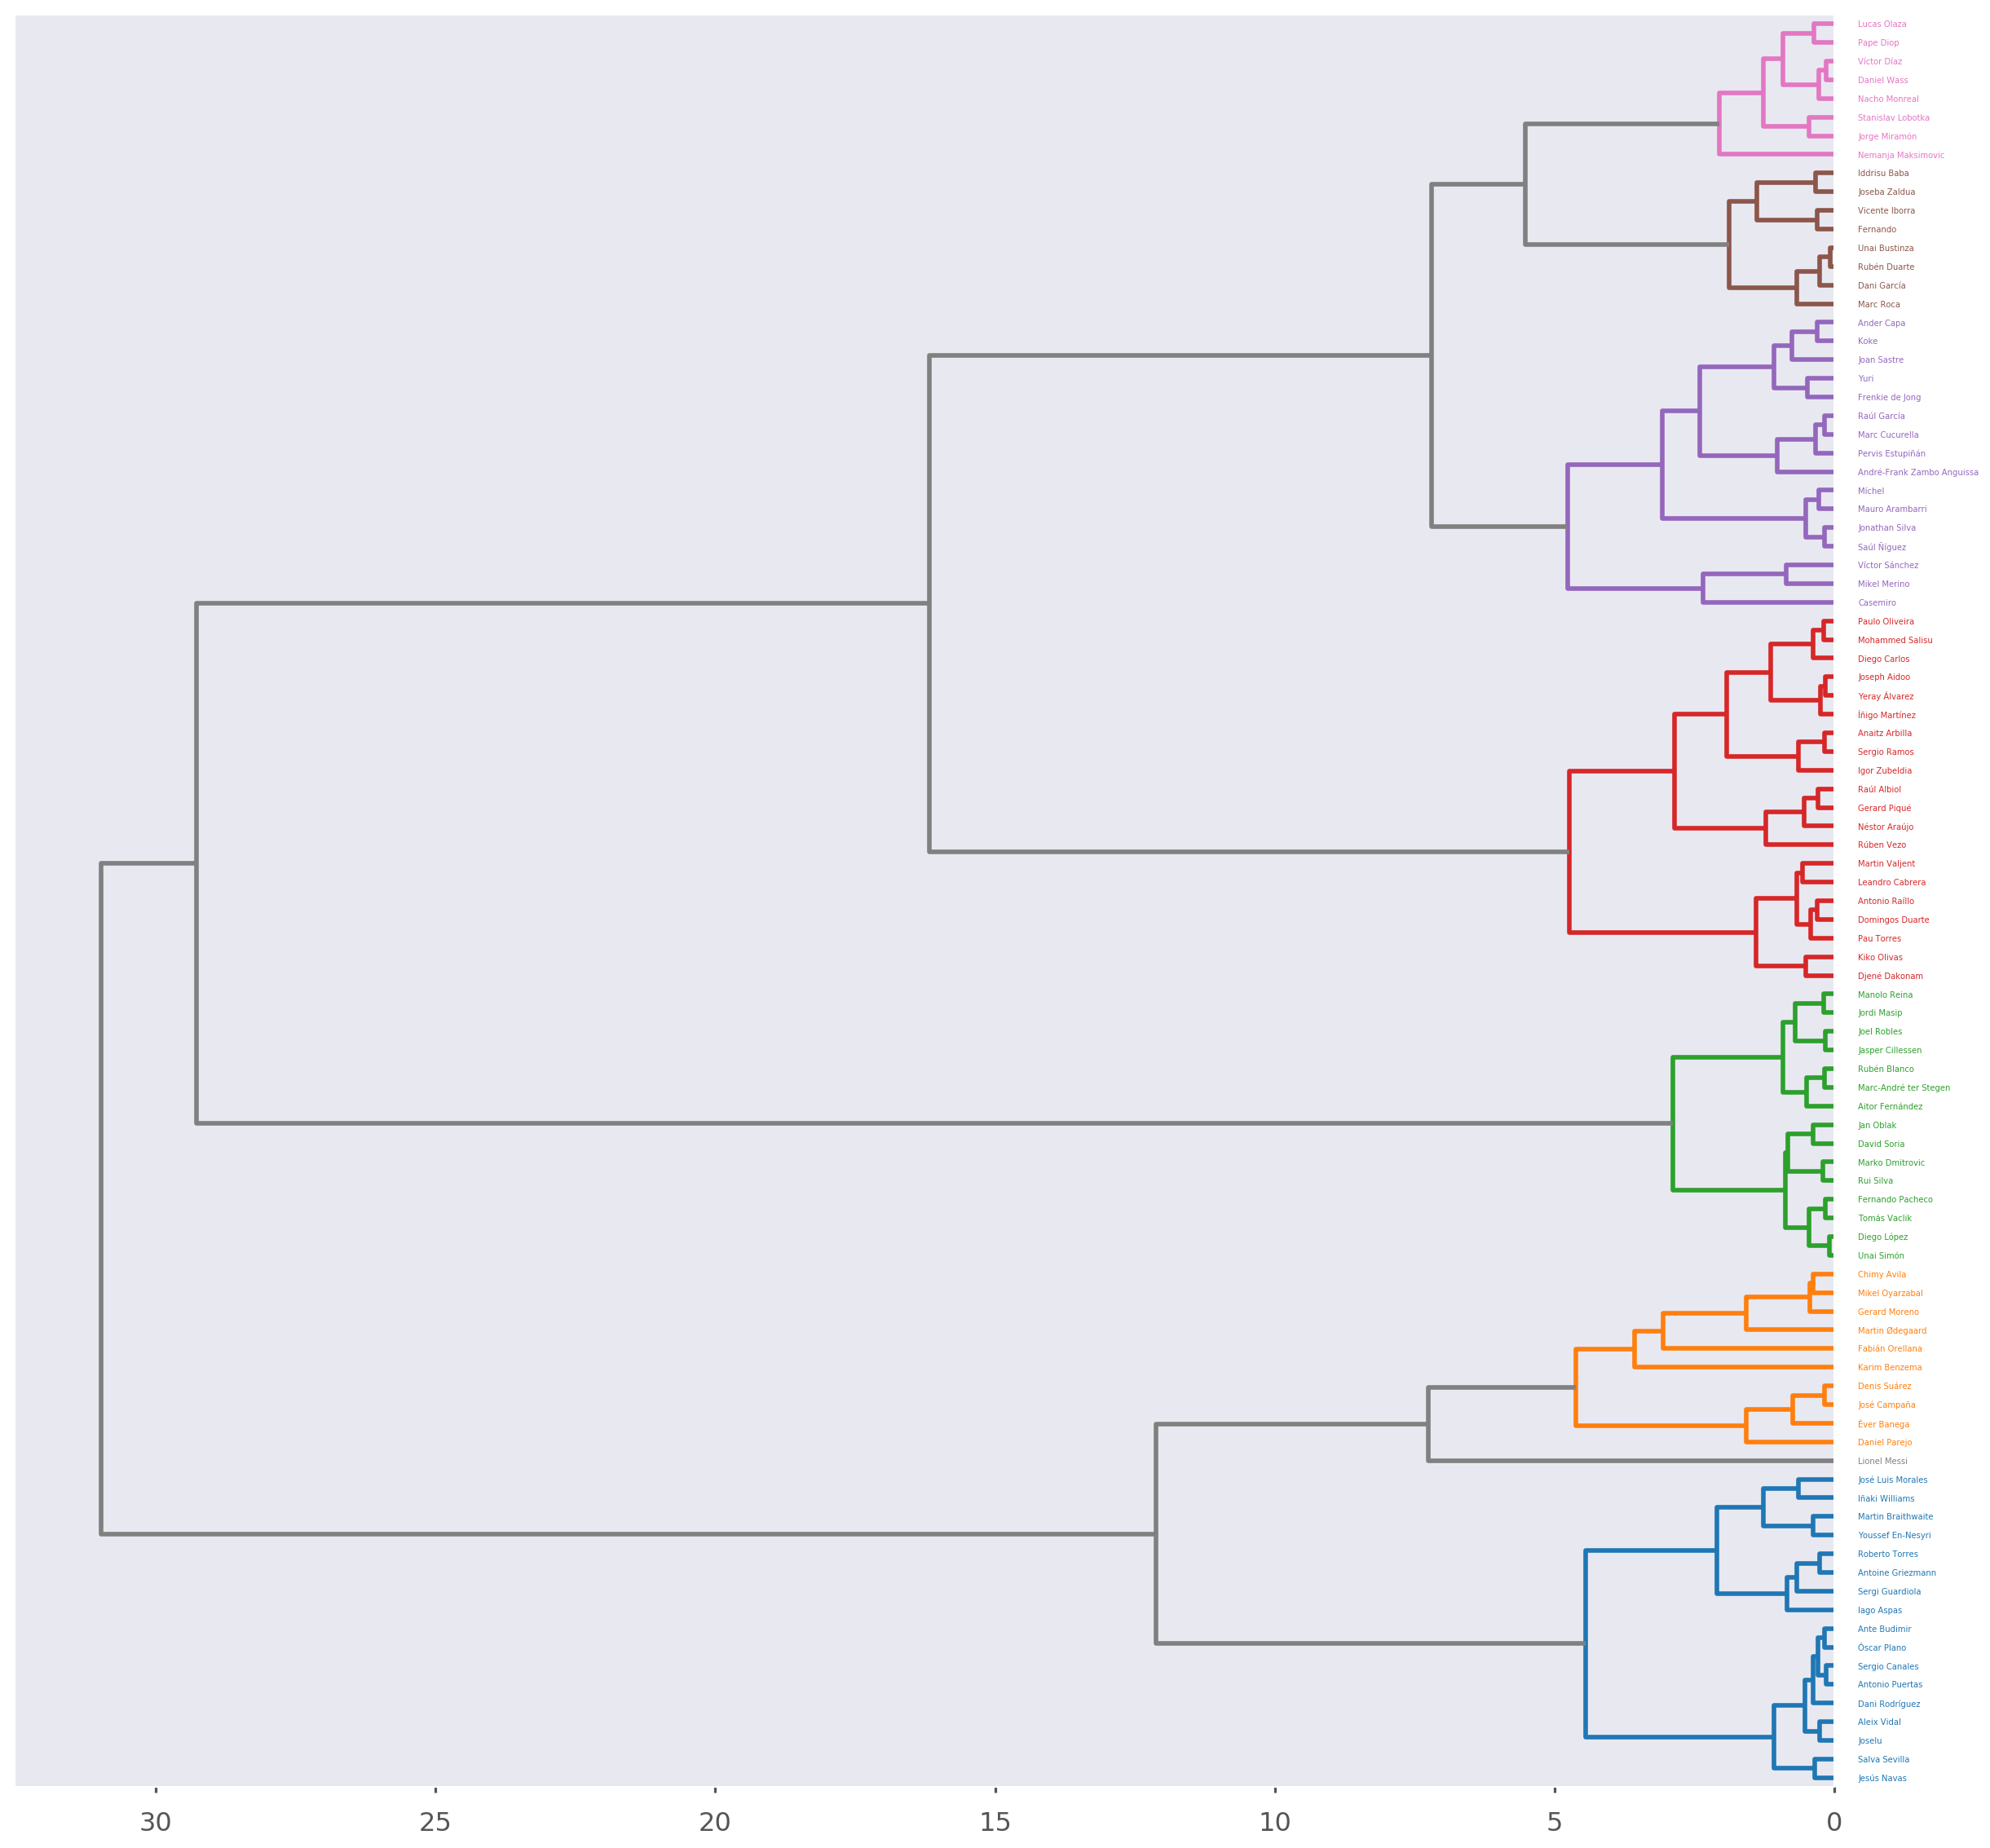

In [31]:
from scipy.cluster import hierarchy

# Create clusters
n_clusters = 5
clusters = cluster.AgglomerativeClustering(n_clusters, affinity='euclidean', linkage='ward')
pred = clusters.fit_predict(principal_df)

# Draw clusters with dendrogram
plt.figure(figsize=(20, 20))
ax = plt.axes()
ax.grid(False)
ax.set_facecolor('#E8E8F1')

# Calculate the distance between each sample
Z = hierarchy.linkage(principal_df, 'ward')


colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


hierarchy.set_link_color_palette(colors)

dend = hierarchy.dendrogram(Z, 
                            color_threshold=n_clusters, 
                            orientation="left", 
                            labels=principal_df.index,
                            above_threshold_color="grey"
                         )

# Helpers
# http://datanongrata.com/2019/04/27/67/
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

def get_key_from_item(dictionary, item):
    for key, items in dictionary.items():    
        if item in items:
            return key

        
color_clusters = get_cluster_classes(dend)

# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
colors_ordered = []
for i, lbl in enumerate(xlbls):
    lbl.set_color(get_key_from_item(color_clusters, lbl.get_text()))
